In [ ]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps" if not torch.cuda.is_available() else "cuda"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)

# Load tokenizer 

meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_89698/2826483081.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


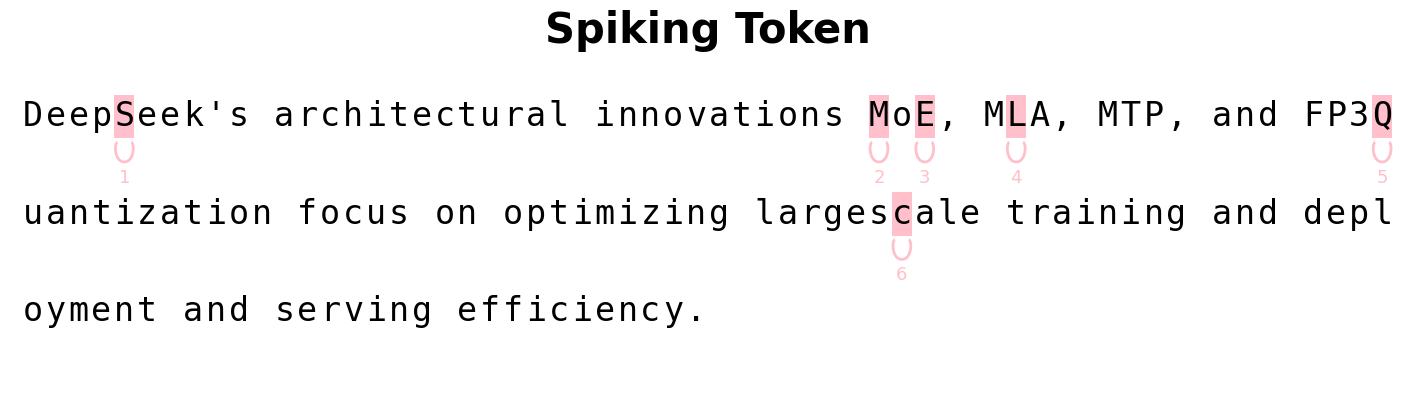

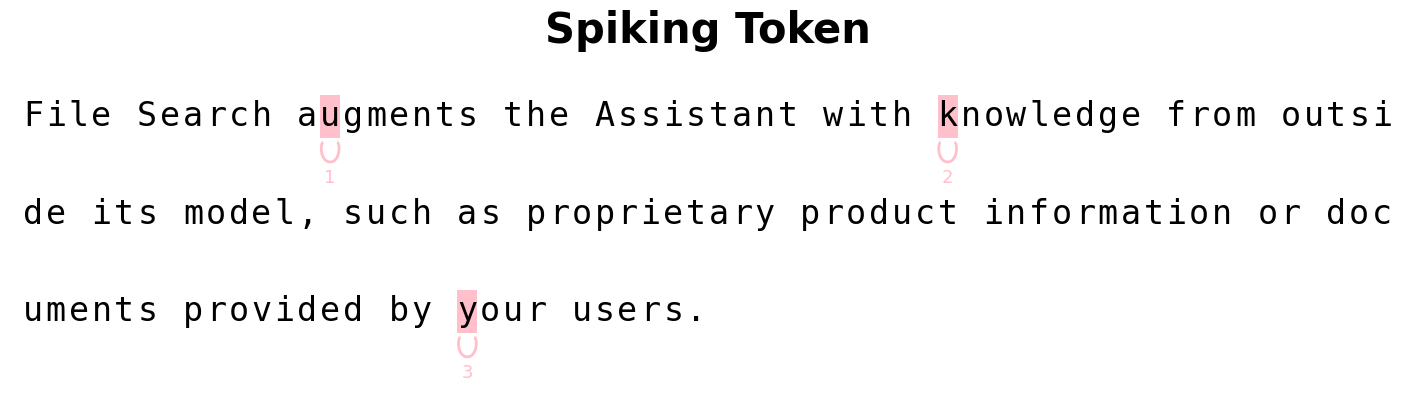

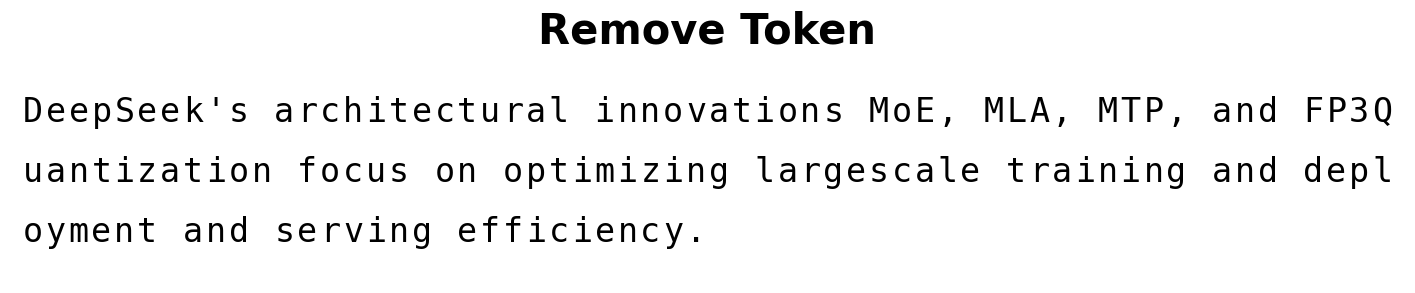

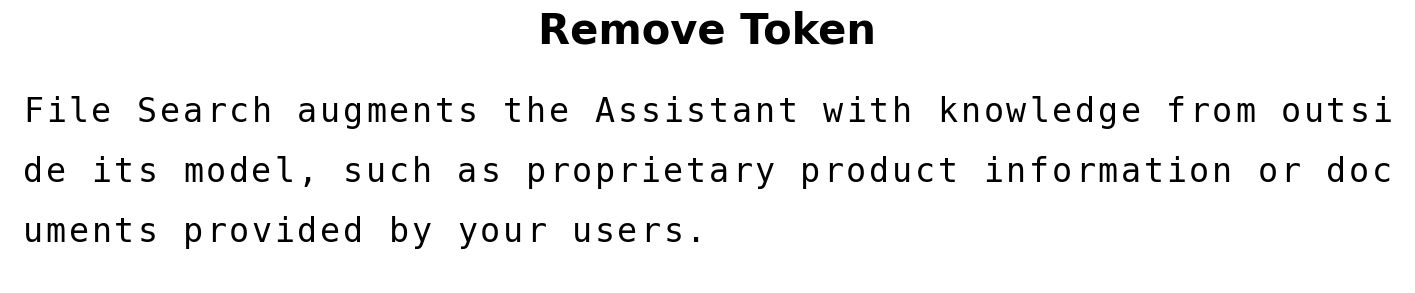

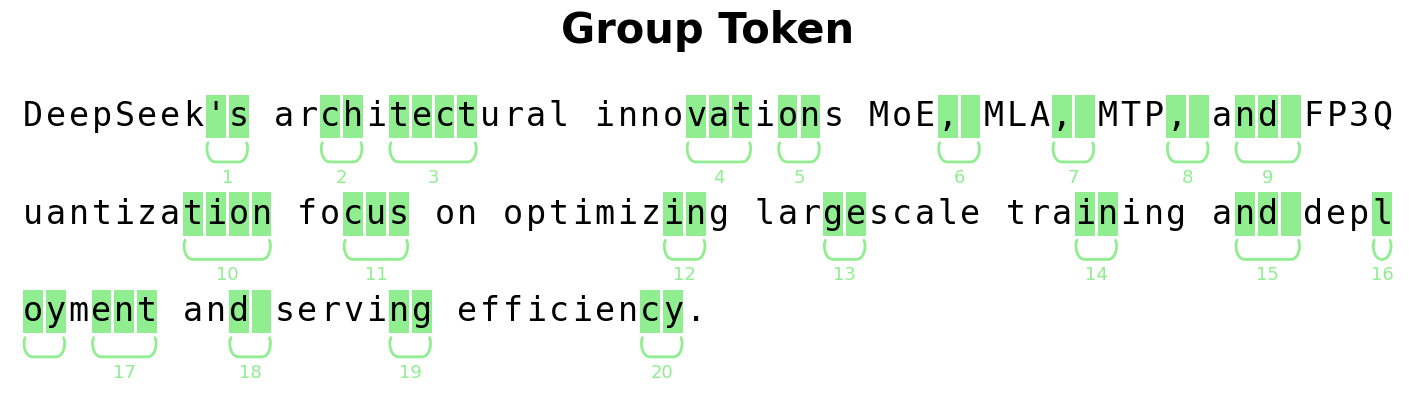

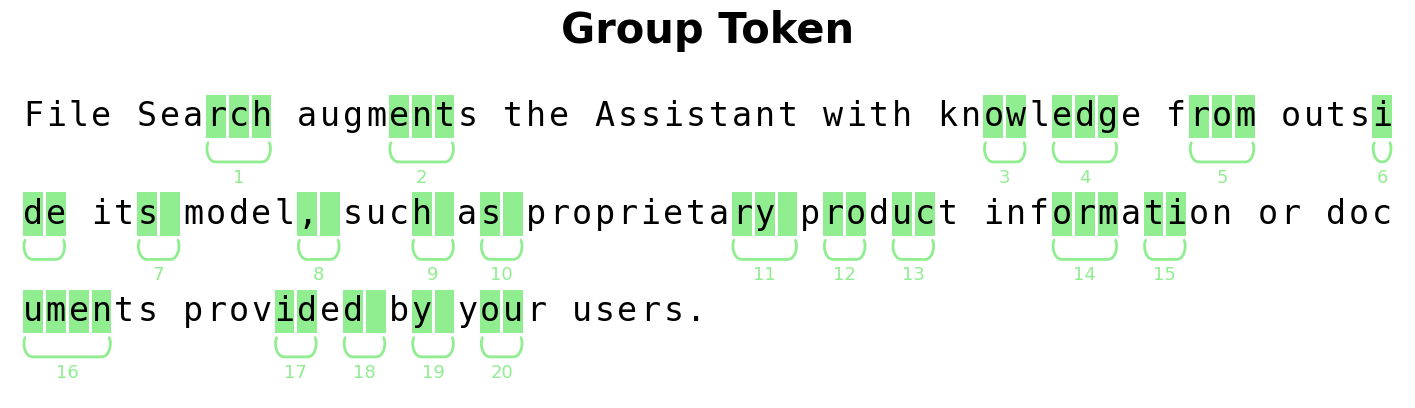

In [2]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=0.2)

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [3]:
# cache vocabulary change 
magicab.cache_vocab_change(texts)

# update vocabulary :: Need to speed-up 'add_token' for ETokenizer 
magicab.update_vocab(max_size_change=100)

Begin vocabulary change caching ...
 - Inference took: 0.0403 seconds
 - Remove token detection took: 0.0003 seconds
 - Group token detection took: 0.0015 seconds
Function _prep_vocabulary_addition took 0.0006 seconds
 - Vocabulary addition (inference required) prep took: 0.0006 seconds
 - Token removal prep took: 0.0001 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.0443 seconds
:: Total 39 token groups, added 54 pairwise merges
:: Total 54 new tokens added
Function add_to_vocab took 0.0011 seconds
:: Total 0 tokens to remove
Function remove_from_vocab took 0.0009 seconds


In [3]:

from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab
import time 

# Update data with tokenizer (11min --> 40s with rust tokenization)
t0 = time.time()
prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 
t1 = time.time()
print("Time taken to update data: ", t1 - t0)

data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "cpu"

# Update vocabulary on training data
# vocabulary grows huge very soon, need to cap on allowed size change
update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change=200) 
t2 = time.time() 
print("Time taken to update vocabulary: ", t2 - t1)

Input file path:  data/enwiki/enwik8_clean.txt
Encoding data with tokenizer ...
Total tokens: 54482072
Vocab size: 92
train has 50,000,000 tokens
val has 2,000,000 tokens
test has 2,482,072 tokens
Time taken to update data:  4.432971954345703


Updating Magicab Vocabulary:   0%|          | 0/763 [00:00<?, ?it/s]

Function _prep_vocabulary_addition took 1.3929 seconds


Updating Magicab Vocabulary:   0%|          | 1/763 [00:14<3:10:23, 14.99s/it]

Function _cache_vocabulary_change took 14.9871 seconds
Function _prep_vocabulary_addition took 3.6860 seconds


Updating Magicab Vocabulary:   0%|          | 2/763 [00:34<3:42:41, 17.56s/it]

Function _cache_vocabulary_change took 19.3495 seconds
Function _prep_vocabulary_addition took 6.0739 seconds


Updating Magicab Vocabulary:   0%|          | 3/763 [00:54<3:55:36, 18.60s/it]

Function _cache_vocabulary_change took 19.8362 seconds
Function _prep_vocabulary_addition took 8.1615 seconds


Updating Magicab Vocabulary:   1%|          | 4/763 [01:20<4:33:41, 21.64s/it]

Function _cache_vocabulary_change took 26.2857 seconds
Function _prep_vocabulary_addition took 10.5408 seconds


Updating Magicab Vocabulary:   1%|          | 5/763 [01:50<5:11:55, 24.69s/it]

Function _cache_vocabulary_change took 30.1005 seconds
Function _prep_vocabulary_addition took 13.3171 seconds


Updating Magicab Vocabulary:   1%|          | 6/763 [02:28<6:09:14, 29.27s/it]

Function _cache_vocabulary_change took 38.1438 seconds
Function _prep_vocabulary_addition took 16.0986 seconds


Updating Magicab Vocabulary:   1%|          | 7/763 [03:14<7:16:16, 34.62s/it]

Function _cache_vocabulary_change took 45.6522 seconds
Function _prep_vocabulary_addition took 17.5207 seconds


Updating Magicab Vocabulary:   1%|          | 8/763 [04:08<8:33:04, 40.77s/it]

Function _cache_vocabulary_change took 53.9336 seconds


Updating Magicab Vocabulary:   1%|          | 8/763 [04:11<6:35:28, 31.43s/it]


KeyboardInterrupt: 

In [ ]:
# Speed is important for updating tokenizer, "add_token" is very slow in python, too


import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)

# Load tokenizer 

meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])


from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab
import time 

# Update data with tokenizer (11min --> 40s with rust tokenization)
t0 = time.time()
prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 
t1 = time.time()
print("Time taken to update data: ", t1 - t0)

data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "cpu"

# Update vocabulary on training data
# vocabulary grows huge very soon, need to cap on allowed size change
update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change=200) 
t2 = time.time() 
print("Time taken to update vocabulary: ", t2 - t1)